features-entry contains a list of a list with 26 items.
- length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))

- length of outer list: number of frames per data-point, e.g. 10 or 15, ...

---

## Machine config

nvidia apex to half-precision

In [1]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Cloning into 'apex'...
remote: Enumerating objects: 8717, done.
remote: Counting objects: 100% (1169/1169), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 8717 (delta 1040), reused 916 (delta 912), pack-reused 7548
Receiving objects: 100% (8717/8717), 14.38 MiB | 17.93 MiB/s, done.
Resolving deltas: 100% (5958/5958), done.
/content/apex
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/

# Audio classification the from-scratch way

We're going to demonstrate the technique of classifying audio samples by first converting the audio into spectrograms, then treating the spectrograms as images. Once we've converted the spectrograms to images, the workflow is just the same as using imagenette or any other image classification task.

What do we need to do?
* Download the data
* Load the data
    - split the data to each element
    - split to train / valid
    - get label
    - zero pad
* Transform the data into spectrograms (skip)
* Load the audio data into a databunch such that we can use our previously-defined `learner` object

Still to come - 1D convolutional models, RNNs with audio… and more, with your contribution :)

# Download the data

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/ser_traindev.tar.gz /content/.
!mkdir /content/data
!mv /content/ser_traindev.tar.gz /content/data
%cd /content/data
!tar -xf /content/data/ser_traindev.tar.gz
%cd /content

In [4]:
!git clone https://github.com/fastai/course-v3/ /content/course-v3

Cloning into '/content/course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.03 MiB | 29.82 MiB/s, done.
Resolving deltas: 100% (3249/3249), done.


In [1]:
# restart-run
%cd /content/course-v3/nbs/dl2
from exp.nb_12a import *
%cd /content

/content/course-v3/nbs/dl2
/content


In [ ]:
import json
with open('/content/data/data-v0/train.json') as f: train_json = json.load(f)

In [ ]:
with open('/content/data/data-v0/dev.json') as f: dev_json = json.load(f)

- AUDIO
    - number of train (and valid) data: 7799
    - number of test data: 3341
- NLU
    - number of train (and valid) data: 10097
    - number of test data: 2886

In [ ]:
!cp /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/nlu_traindev.tar.gz /content/tmp
%cd /content/tmp

/content/tmp


In [ ]:
!tar -xf /content/tmp/nlu_traindev.tar.gz

In [ ]:
# export
def get_jsons(d):
    d = Path(d)
    with (d/'train.json').open() as f: train_json = json.load(f)
    with (d/'dev.json').open() as f: dev_json = json.load(f)
    return train_json, dev_json

In [ ]:
nlu_train, nlu_dev = get_jsons('/content/tmp')
list(nlu_train.keys())[-1], list(nlu_dev.keys())[-1]

In [ ]:
del nlu_train, nlu_dev; gc.collect()

809

# Load the data
- ~~split the data to each element~~
- split to train / valid (using DataBlock of fastai)
- get label
- zero pad

In [ ]:
train_path = data_root/'train'
(train_path).mkdir(parents=True, exist_ok=True)

dev_path = data_root/'dev'
(dev_path).mkdir(parents=True, exist_ok=True)

In [ ]:
data_root.ls()

[PosixPath('/content/data/ser/train'), PosixPath('/content/data/ser/dev')]

- The rule of naming
    - 'data/ser/train/{index}_y1_y2'
        - y1 : activation
        - y2 : valence

In [ ]:
for data_id, vals in train_json.items():
    v = tensor(vals['features'])
    torch.save(v, train_path/f"{data_id}_{vals['activation']}_{vals['valence']}.pt")

In [ ]:
for data_id, vals in dev_json.items():
    v = tensor(vals['features'])
    torch.save(v, dev_path/f"{data_id}.pt")

In [ ]:
del train_json, dev_json

In [ ]:
import gc
gc.collect()

619

In [ ]:
# save for later

!cp -R /content/data /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/data

In [8]:
!ls /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/data/

data-v0/  ser/


In [ ]:
%cd /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/data
!tar -zcvf ser.tar.gz ser

In [11]:
!rm -rf /content/ser.tar.gz

In [12]:
%cd /content/

/content


In [13]:
!cp /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/data/ser.tar.gz /content/.

In [ ]:
!tar -xvzf ser.tar.gz

In [ ]:
train_path.ls().__len__(), dev_path.ls().__len__()

(7800, 3342)

We rely heavily on [torchaudio](https://github.com/pytorch/audio) - which you'll have to compile to install.

In [9]:
data_root = Path('/content/ser')

In [10]:
train_path = data_root/'train'

In [12]:
audios = get_files(train_path)

In [11]:
# restart-run
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)

In [13]:
al=AudioList.from_files(train_path); al

AudioList (7800 items)
[PosixPath('/content/ser/train/214_1_0.pt'), PosixPath('/content/ser/train/4963_1_0.pt'), PosixPath('/content/ser/train/2154_1_0.pt'), PosixPath('/content/ser/train/2957_1_0.pt'), PosixPath('/content/ser/train/4957_1_1.pt'), PosixPath('/content/ser/train/941_1_1.pt'), PosixPath('/content/ser/train/1051_1_0.pt'), PosixPath('/content/ser/train/2633_1_1.pt'), PosixPath('/content/ser/train/2935_1_0.pt'), PosixPath('/content/ser/train/7276_1_0.pt')...]
Path: /content/ser/train

In [ ]:
al[0].shape

torch.Size([197, 26])

In [14]:
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))

- we have two labels, which are activation and valence. I will first try to classify them separately.

In [3]:
# restart-run
def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return re.findall(pat, str(fn))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]

In [15]:
# restart-run
label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat)
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [ ]:
re.findall(label_pat, str(list(sd.train)[0]))

['1', '0']

In [ ]:
ll

SplitData
Train: LabeledData
x: AudioList (6193 items)
[PosixPath('/content/data/ser/train/1734_1_0.pt'), PosixPath('/content/data/ser/train/7264_1_1.pt'), PosixPath('/content/data/ser/train/5083_1_1.pt'), PosixPath('/content/data/ser/train/2247_1_1.pt'), PosixPath('/content/data/ser/train/1744_1_1.pt'), PosixPath('/content/data/ser/train/4635_1_0.pt'), PosixPath('/content/data/ser/train/4747_0_1.pt'), PosixPath('/content/data/ser/train/3828_1_1.pt'), PosixPath('/content/data/ser/train/529_1_1.pt'), PosixPath('/content/data/ser/train/2975_1_1.pt')...]
Path: /content/data/ser/train
y: ItemList (6193 items)
[0, 1, 1, 1, 1, 0, 1, 1, 1, 1...]
Path: /content/data/ser/train

Valid: LabeledData
x: AudioList (1607 items)
[PosixPath('/content/data/ser/train/4310_0_0.pt'), PosixPath('/content/data/ser/train/5159_1_0.pt'), PosixPath('/content/data/ser/train/4662_1_0.pt'), PosixPath('/content/data/ser/train/2330_0_0.pt'), PosixPath('/content/data/ser/train/2696_1_0.pt'), PosixPath('/content/data/s

In [16]:
class ToCuda(Transform):
    _order=10
    def __call__(self, ad): return ad.cuda()

In [ ]:
ToCuda()(ll.train[0][0]).type()

'torch.cuda.FloatTensor'

In [27]:
import torchaudio
from torchaudio import transforms
dir(transforms)

['AmplitudeToDB',
 'Callable',
 'ComplexNorm',
 'ComputeDeltas',
 'F',
 'Fade',
 'FrequencyMasking',
 'GriffinLim',
 'InverseMelScale',
 'InverseSpectrogram',
 'LFCC',
 'MFCC',
 'MVDR',
 'MelScale',
 'MelSpectrogram',
 'MuLawDecoding',
 'MuLawEncoding',
 'Optional',
 'PSD',
 'PitchShift',
 'RNNTLoss',
 'Resample',
 'SlidingWindowCmn',
 'SpectralCentroid',
 'Spectrogram',
 'Tensor',
 'TimeMasking',
 'TimeStretch',
 'Vad',
 'Vol',
 '_AxisMasking',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_apply_sinc_resample_kernel',
 '_get_mat_trace',
 '_get_sinc_resample_kernel',
 'math',
 'torch',
 'warnings']

- let's see the distribution of frames to pad

In [ ]:
max(len_dist)

1707

(array([3.490e+03, 1.812e+03, 6.000e+02, 1.860e+02, 7.700e+01, 1.600e+01, 5.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([  30. ,  197.7,  365.4,  533.1,  700.8,  868.5, 1036.2, 1203.9, 1371.6, 1539.3, 1707. ]),
 <a list of 10 Patch objects>)

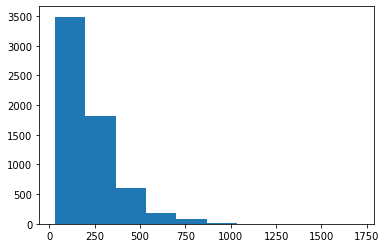

In [ ]:
plt.hist(len_dist)

- let me see the 80 percent point

In [ ]:
get_pct(len_dist, 0.90)

421

In [ ]:
# number of time frames and filter banks
t, fb = sd.train[0].shape; t, fb

(197, 26)

In [ ]:
pad_size = 422 - t; pad_size

225

In [120]:
class PadorTrim():
    _order = 11
    def __init__(self, max_len):
        self.max_len = max_len
    def __call__(self, ad):
        # number of time frames and filter banks
        t, fb = ad.shape
        pad_size = self.max_len - t
        if pad_size >0: return torch.concat((ad, torch.zeros(pad_size, fb).cuda()))
        else: return ad[:self.max_len, :]

In [143]:
class Reshape():
    _order = 12
    def __call__(self, ad):
        return ad.permute(1, 0).unsqueeze(1)

In [157]:
m = 250
tfms = [ToCuda(), PadorTrim(m), Reshape()]
al = AudioList.from_files(train_path, tfms=tfms)
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))
emotion_labeler = partial(re_labeler, pat=label_pat, subcl='val') #default: activaiton
# emotion_labeler = partial(re_labeler, pat=label_pat)
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [158]:
bs=64
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [159]:
c_in, c_out

(26, 2)

# Train the data

In [160]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
loss_func = LabelSmoothingCrossEntropy()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr),
ParamScheduler('mom', sched_mom)]

- Activation

In [148]:
# pad 250, channel = 26
learn = cnn_learner(xresnet34, data, loss_func, opt_func)
learn.fit(5, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.691818,0.581046,0.709811,0.581569,00:09
1,0.674058,0.607846,0.755843,0.569116,00:09
2,0.661072,0.611721,0.713314,0.564134,00:09
3,0.643681,0.631418,0.897190,0.470735,00:09
4,0.623656,0.664998,0.624798,0.658157,00:09


- Valence

In [161]:
# pad 250, channel = 26
learn = cnn_learner(xresnet34, data, loss_func, opt_func)
learn.fit(5, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.689944,0.598069,0.911223,0.564669,00:09
1,0.677119,0.591633,0.915761,0.567192,00:09
2,0.661111,0.612068,0.713597,0.540063,00:09
3,0.640533,0.632824,0.805456,0.488328,00:09
4,0.621881,0.659855,0.637190,0.652997,00:09


In [126]:
# pad 250, channel = 1
learn = cnn_learner(xresnet34, data, loss_func, opt_func)
learn.fit(5, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.683508,0.602578,0.647383,0.636124,00:12
1,0.677025,0.599554,0.670912,0.628214,00:12
2,0.669488,0.612128,0.648386,0.665129,00:12
3,0.631449,0.651281,0.658465,0.657218,00:12
4,0.606901,0.681840,0.610676,0.690178,00:12


In [96]:
# pad 442, channel = 1
learn = cnn_learner(xresnet34, data, loss_func, opt_func)
learn.fit(5, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.682259,0.602908,0.675752,0.616149,00:18
1,0.673281,0.601454,1.419197,0.437888,00:17
2,0.667901,0.608885,0.635013,0.642857,00:18
3,0.640790,0.646204,0.648923,0.631056,00:18
4,0.618470,0.671082,0.617194,0.672671,00:17


### dev test

In [ ]:
# dev_data = 

In [162]:
res = []
for i in range(len(dev_path.ls())):
    res += [learn.model(dev_data[i].unsqueeze(2)).cpu().argmax().item()]

In [163]:
import pickle
with open('/content/res/ser-v3-valence.pkl', 'wb') as f: pickle.dump(res, f)

# Reform to submit

In [103]:
!tar -xvzf ser_traindev.tar.gz

train.json
dev.json


In [164]:
with open('/content/res/ser-v3-activation.pkl', 'rb') as f: act_pred = pickle.load(f)

In [165]:
with open('/content/res/ser-v3-valence.pkl', 'rb') as f: val_pred = pickle.load(f)

In [108]:
len(act_pred), len(val_pred)

(3342, 3342)

In [166]:
res_dict = {}
for idx in range(len(act_pred)):
    k = str(idx)
    res_dict[k] = {}
    res_dict[k]['activation'] = act_pred[idx]
    res_dict[k]['valence'] = val_pred[idx]

In [167]:
with open('/content/res/ser-v3.json', 'w') as f: json.dump(res_dict, f)

In [116]:
!mv /content/re

In [141]:
!cp -r /content/res/ /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/

In [142]:
!ls /gdrive/Shareddrives/Dion-Account/2122WS/dl4slp/coding-project/res

ser  ser-v2-activation.pkl  ser-v2.json  ser-v2-valence.pkl


## Inspect the size of tensor and visualize

In [43]:
ll.train[2][0].shape

torch.Size([1, 26, 442])

In [44]:
def show_spectro(img, ax=None, figsize=(6,6), with_shape=True):
    if hasattr(img,"device") & str(img.device).startswith("cuda"): img = img.cpu()
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    img2 = img if (img.shape[0]==3) else img.squeeze(0)

    ax.imshow(img2)
    if with_shape: display(f'Tensor shape={img.shape, img2.shape}')

In [45]:
ll.train[0][0].shape, ll.train[0][0].squeeze(0).shape

(torch.Size([1, 26, 442]), torch.Size([26, 442]))

---

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
def show_batch(x, c=4, r=None, figsize=None, shower=show_image):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): shower(xi, ax)
show_spec_batch = partial(show_batch, c=4, r=2, figsize=None, 
                          shower=partial(show_spectro, with_shape=False))
show_spec_batch(x)    

---